## Network analysis of rs MEG data 

We follow the analysis outlined in 
Deco et al., *Single or multiple frequency generators in on-going brain activity: A mechanistic whole-brain model of empirical MEG data*, NeuroImage, 2017 (see also Cabral et al., *Exploring mechanisms of spontaneous functional connectivity in MEG: How delayed network interactions lead to structured amplitude envelopes of band-pass filtered oscillations*, NeuroImage, 2014 and Brookes et al., *Measuring functional connectivity in MEG: A multivariate approach insensitive to linear source leakage*, NeuroImage, 2012).

Basically, we band-pass filter source-space signal for each carrier frequency band, calculate the amplitude envelope (using a Hilbert transform of the orthogonalized time courses; this is to remove zero-lag correlations due to signal leakage), low-pass filter this envelope (0.2Hz-0.5Hz as threshold have been used in the literature)  so that the ultra-slow fluctuations survive (this is supposed to maximize meaningful resting-state functional connectivity) and then calculate the correlation (Pearson correlation) to obtain functional connectivity matrices. We would then perform the graph analysis on the obtained FC matrices. 

As for the metastability and coherence connectivity dynamics, these are based on the instantaneous phases obtained after the Hilbert transform of the band-pass filtered source-space signals. Metastability gives a measure of the fluctuation of gloabl synchronization between brain areas over time. It is calculated as the Kuramoto order parameter of the phases over all regions. Since this does not tell us anything about the time-depencies in the phase space, we also use the coherence connectivity dynamics, i.e. a time-by-time matrix of the cosine similarity of instantaneous coherence vectors of all (undirected) pairs of nodes.

This notebook performs the initial extraction of the amplitude envelopes and the FC matrices

In [1]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py
import scipy.io
import mat73
from mne.filter import filter_data
from scipy.signal import hilbert
#from neurolib.utils.functions import fc
import networkx as nx
%matplotlib inline

### Load data

In [3]:
data_dir = r'/mnt/antares_raid/home/fkamp/Glasgow_rsMEG/MEG-Data'
os.chdir(data_dir) # Change directory to Data-Directory
Subject = 'S126'

data_file=mat73.loadmat(Subject+'_AAL90_norm2.mat') # Load matfile using mat73
print(data_file.keys())
print(data_file['AAL90_norm'].keys())

dict_keys(['AAL90_norm'])
dict_keys(['fsample', 'grad', 'label', 'time', 'trial'])


In [4]:
fsample = int(data_file['AAL90_norm']['fsample'])
print(fsample)

signals = data_file['AAL90_norm']['trial'][0]
print(np.shape(signals))

time = data_file['AAL90_norm']['time'][0]
print(len(time))

400
(120001, 90)
120001


In [6]:
N = signals.shape[1] # Number of regions = 90
T = signals.shape[0] # Number of timepoints = 120001

### Plot raw-Signal

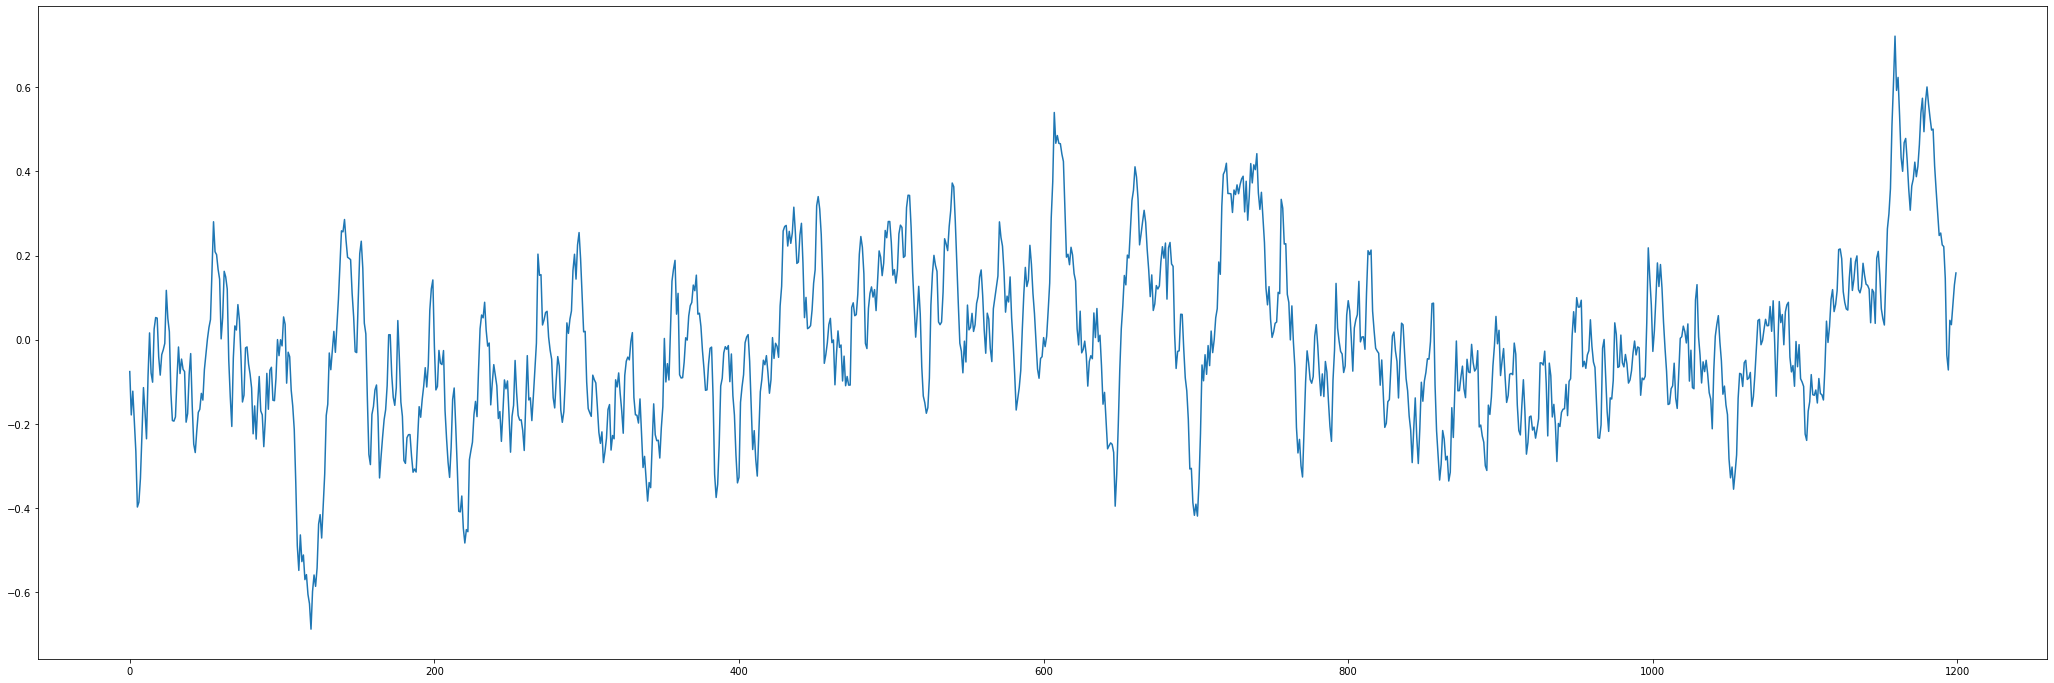

In [7]:
plt.figure(figsize=(36,12))
plt.plot(signals[:1200,0])

### Band-pass filter 

In [13]:
fcarrier = np.arange(4,30,2) # Carrier frequencies
dict_fband = {f: [f-2, f+2] for f in fcarrier} # Carrier frequencies +/-2

dict_signals = {} # Initialize signal dictionary
for signal_name, fband in dict_fband.items(): # Iteration over different frequency bands
    signal = np.zeros((N,T)) # Initialize signal matrix 
    for n in range(N):
        signal[n,:] = filter_data(signals[:,n], fsample, fband[0], fband[1], fir_window='hamming',verbose=False) # bandpass signal
    dict_signals[signal_name]=signal
print(dict_signals.keys())

dict_keys([4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28])


### Plot Band-Pass Signal

Text(0.5, 1.0, 'Carrier Frequency 28 Hz')

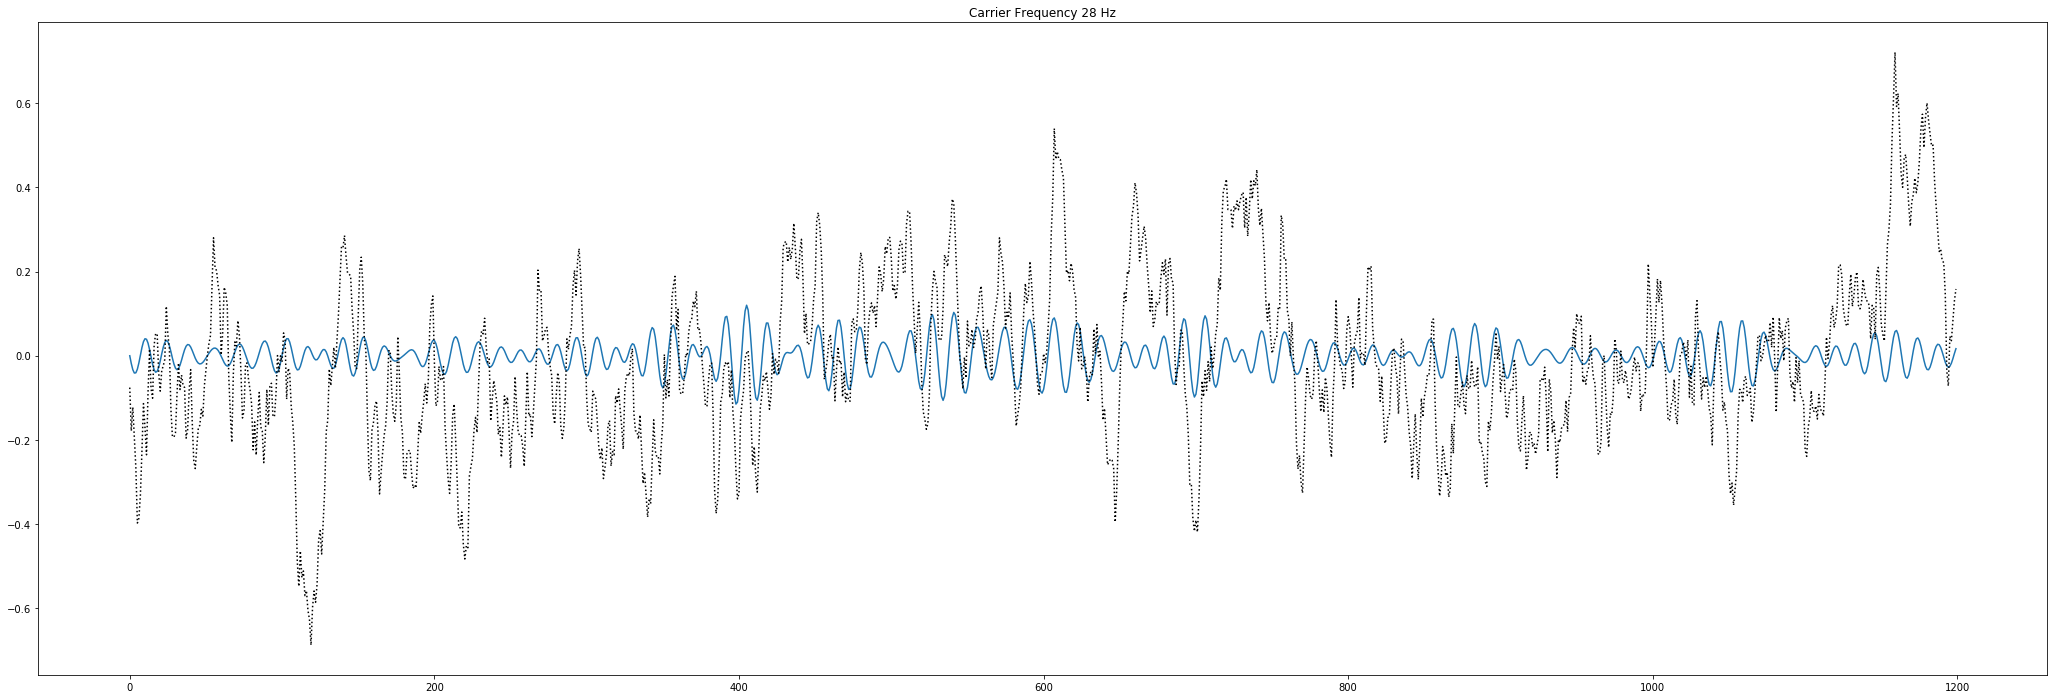

In [16]:
# Plot signal that is specified as plot_signal
plot_signal= 28 
timepoints = 1200
plt.figure(figsize=(36,12))
plt.plot(dict_signals[plot_signal][0, :timepoints])
plt.plot(signals[:timepoints,0], ':k')
plt.title(f"Carrier Frequency {plot_signal} Hz")

### Pairwise Orthogonalization and Extraction of Low-Pass filtered Envelope

Following Brookes et al.,NeuroImage, 2012 and Hipp et al., Nature Neuroscience, 2012. 

The orthogonalized signal (Y_orth) is calculated as im(Y*(X^*/|X|)), where X^* denotes the complex conjugate of X. Ortogonalization is done pairwise in both directions (since it yields different results depending on whether Y is 
orthogonalized wrt X or vice versa) and the calculated correlation coefficients are averaged in the following step.

Brookes et al state that the ortogonalization can be done on the original time series! --> But we do it on the bandbpassed data
this implementation follows the MNE envelope correlation function, however, with the additional step of low-pass filtering the ortogonalized amplitude envelopes

In [17]:
from mne.filter import next_fast_len

##########################################
# TODO: Set frequency for lowpass filter #
##########################################

lower_frequency = 0.0
upper_frequency = 0.2

dict_mag = {}
dict_orth_mag = {}

dict_low_mag = {} # Initialize dictionary for low pass envelope
dict_low_orth_mag = {} # Initialize dictionary for low pass orthogonalized envelope

dict_orth = {} # Initialize dictionary for the orthogonalized signal

for signal_name, signal in dict_signals.items():
    # 1. Step get the shape of the data
    N,T = signal.shape # Shape 90, 120001
    
    # 2. Get number of fourier components in signal
    n_fft = next_fast_len(T)
    
    # 3. Get complex signal
    complex_signal = hilbert(signal, N=n_fft, axis=-1)[:,:T]
    if complex_signal.dtype not in (np.complex64, np. complex128):
        raise ValueError('Could not convert to complex')
    
    # 4. Get envelope and save to dictionary
    signal_mag = np.abs(complex_signal)
    dict_mag[signal_name] = signal_mag
    
    # 5. Low-pass filter the Envelope
    low_mag = filter_data(signal_mag, fsample, 0, upper_frequency, fir_window='hamming',verbose=False) # low pass filter 
    dict_low_mag[signal_name]=low_mag # Save the low-pass filtered data to dictionary
       
    # 5. Get complex conjugate 
    signal_conj = complex_signal.conj() 
    
    # 6. Orthogonalize Data regionwise
    orth_mag = np.empty((N,N,T))
    low_orth_mag = np.empty((N,N,T)) # Initialize matrix for orthogonalized data 
    orth = np.empty((N,N,T))
    for n, n_complex_signal in enumerate(complex_signal):
        n_orth = (n_complex_signal * (signal_conj/signal_mag)).imag # Shape: 90,120001
        orth[n,:,:] = n_orth # The nxt orth signal matrix of region n is saved at nth position in orth array
        
        n_orth_mag = np.abs(n_orth) # Gets the envelope of the orth signal
        orth_mag[n,:,:] = n_orth_mag # Orth magnitude matrix orth mag contains in n the envelope of n orthogonalized to every other signal.
        
        # Lowpass filter the orthogonalized signal
        n_low_orth_mag = filter_data(n_orth_mag, fsample, lower_frequency, upper_frequency, fir_window='hamming', verbose=False) # lowpass envelope
        low_orth_mag[n,:,:] = n_low_orth_mag # Save orthogonalized signal to list of 2dimensional arrays

    # 9. Save orthogonalized data to dictionary
    dict_orth_mag[signal_name] = orth_mag
    dict_low_orth_mag[signal_name] = low_orth_mag
    dict_orth[signal_name] = orth

### Plot Envelope and Low-Pass Envelope

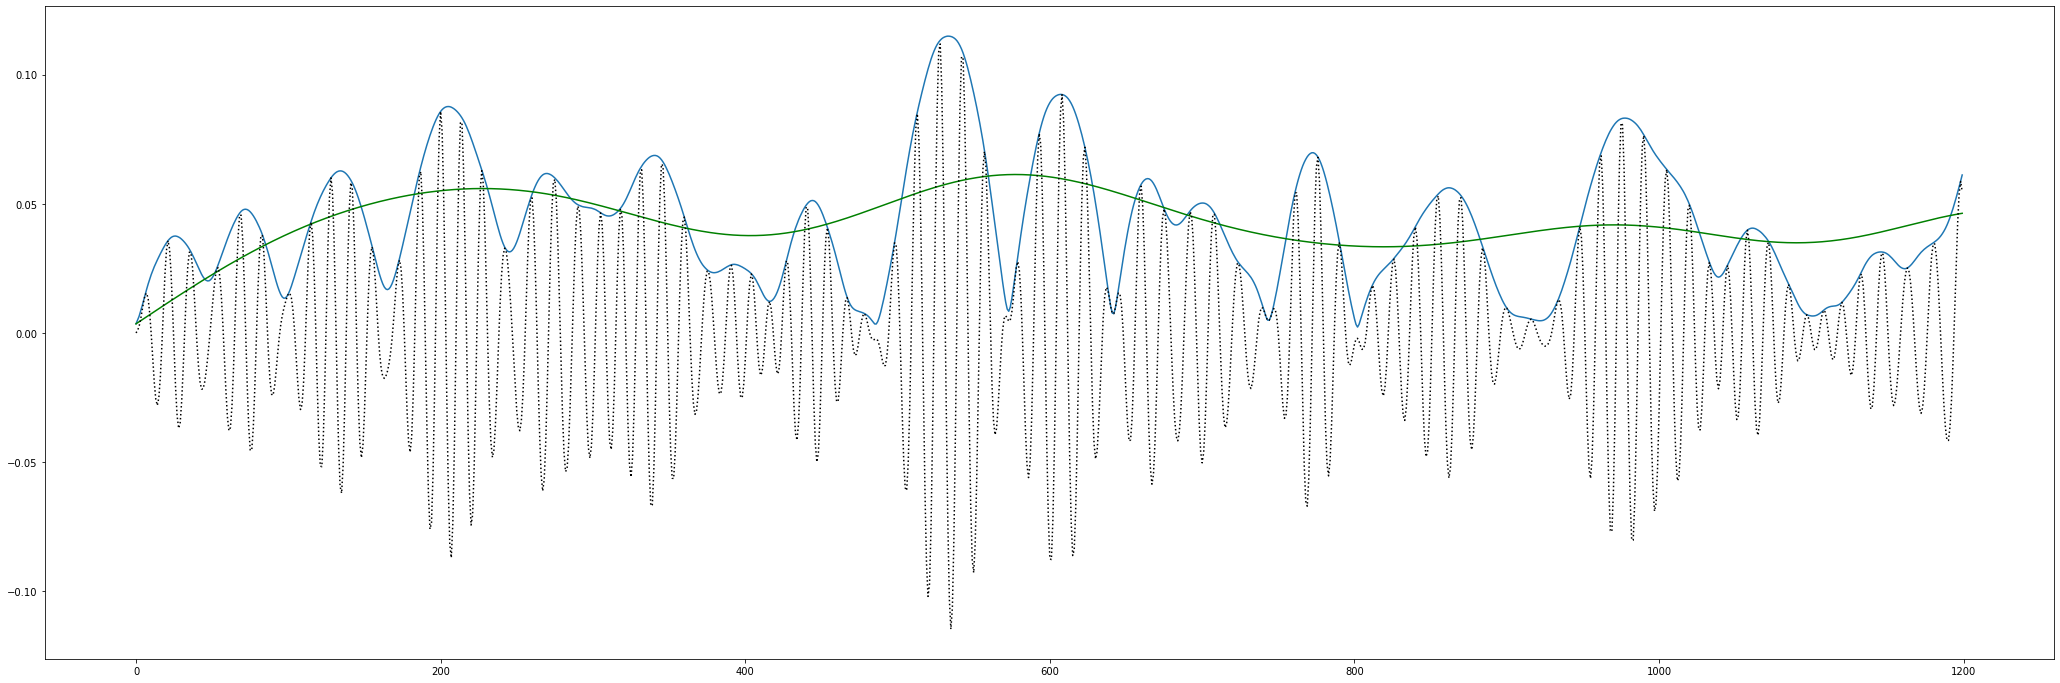

In [22]:
plot_signal = 28 # Specifiy which signal to plot
timepoints = 1200 # Specify number of timepoints
region = 1

plt.figure(figsize=(36,12))
plt.plot(dict_mag[plot_signal][region,:timepoints])
plt.plot(dict_low_mag[plot_signal][region,:timepoints], 'g')
plt.plot(dict_signals[plot_signal][region,:timepoints], ':k')

### Plot Orthogonal Amplitude Envelope

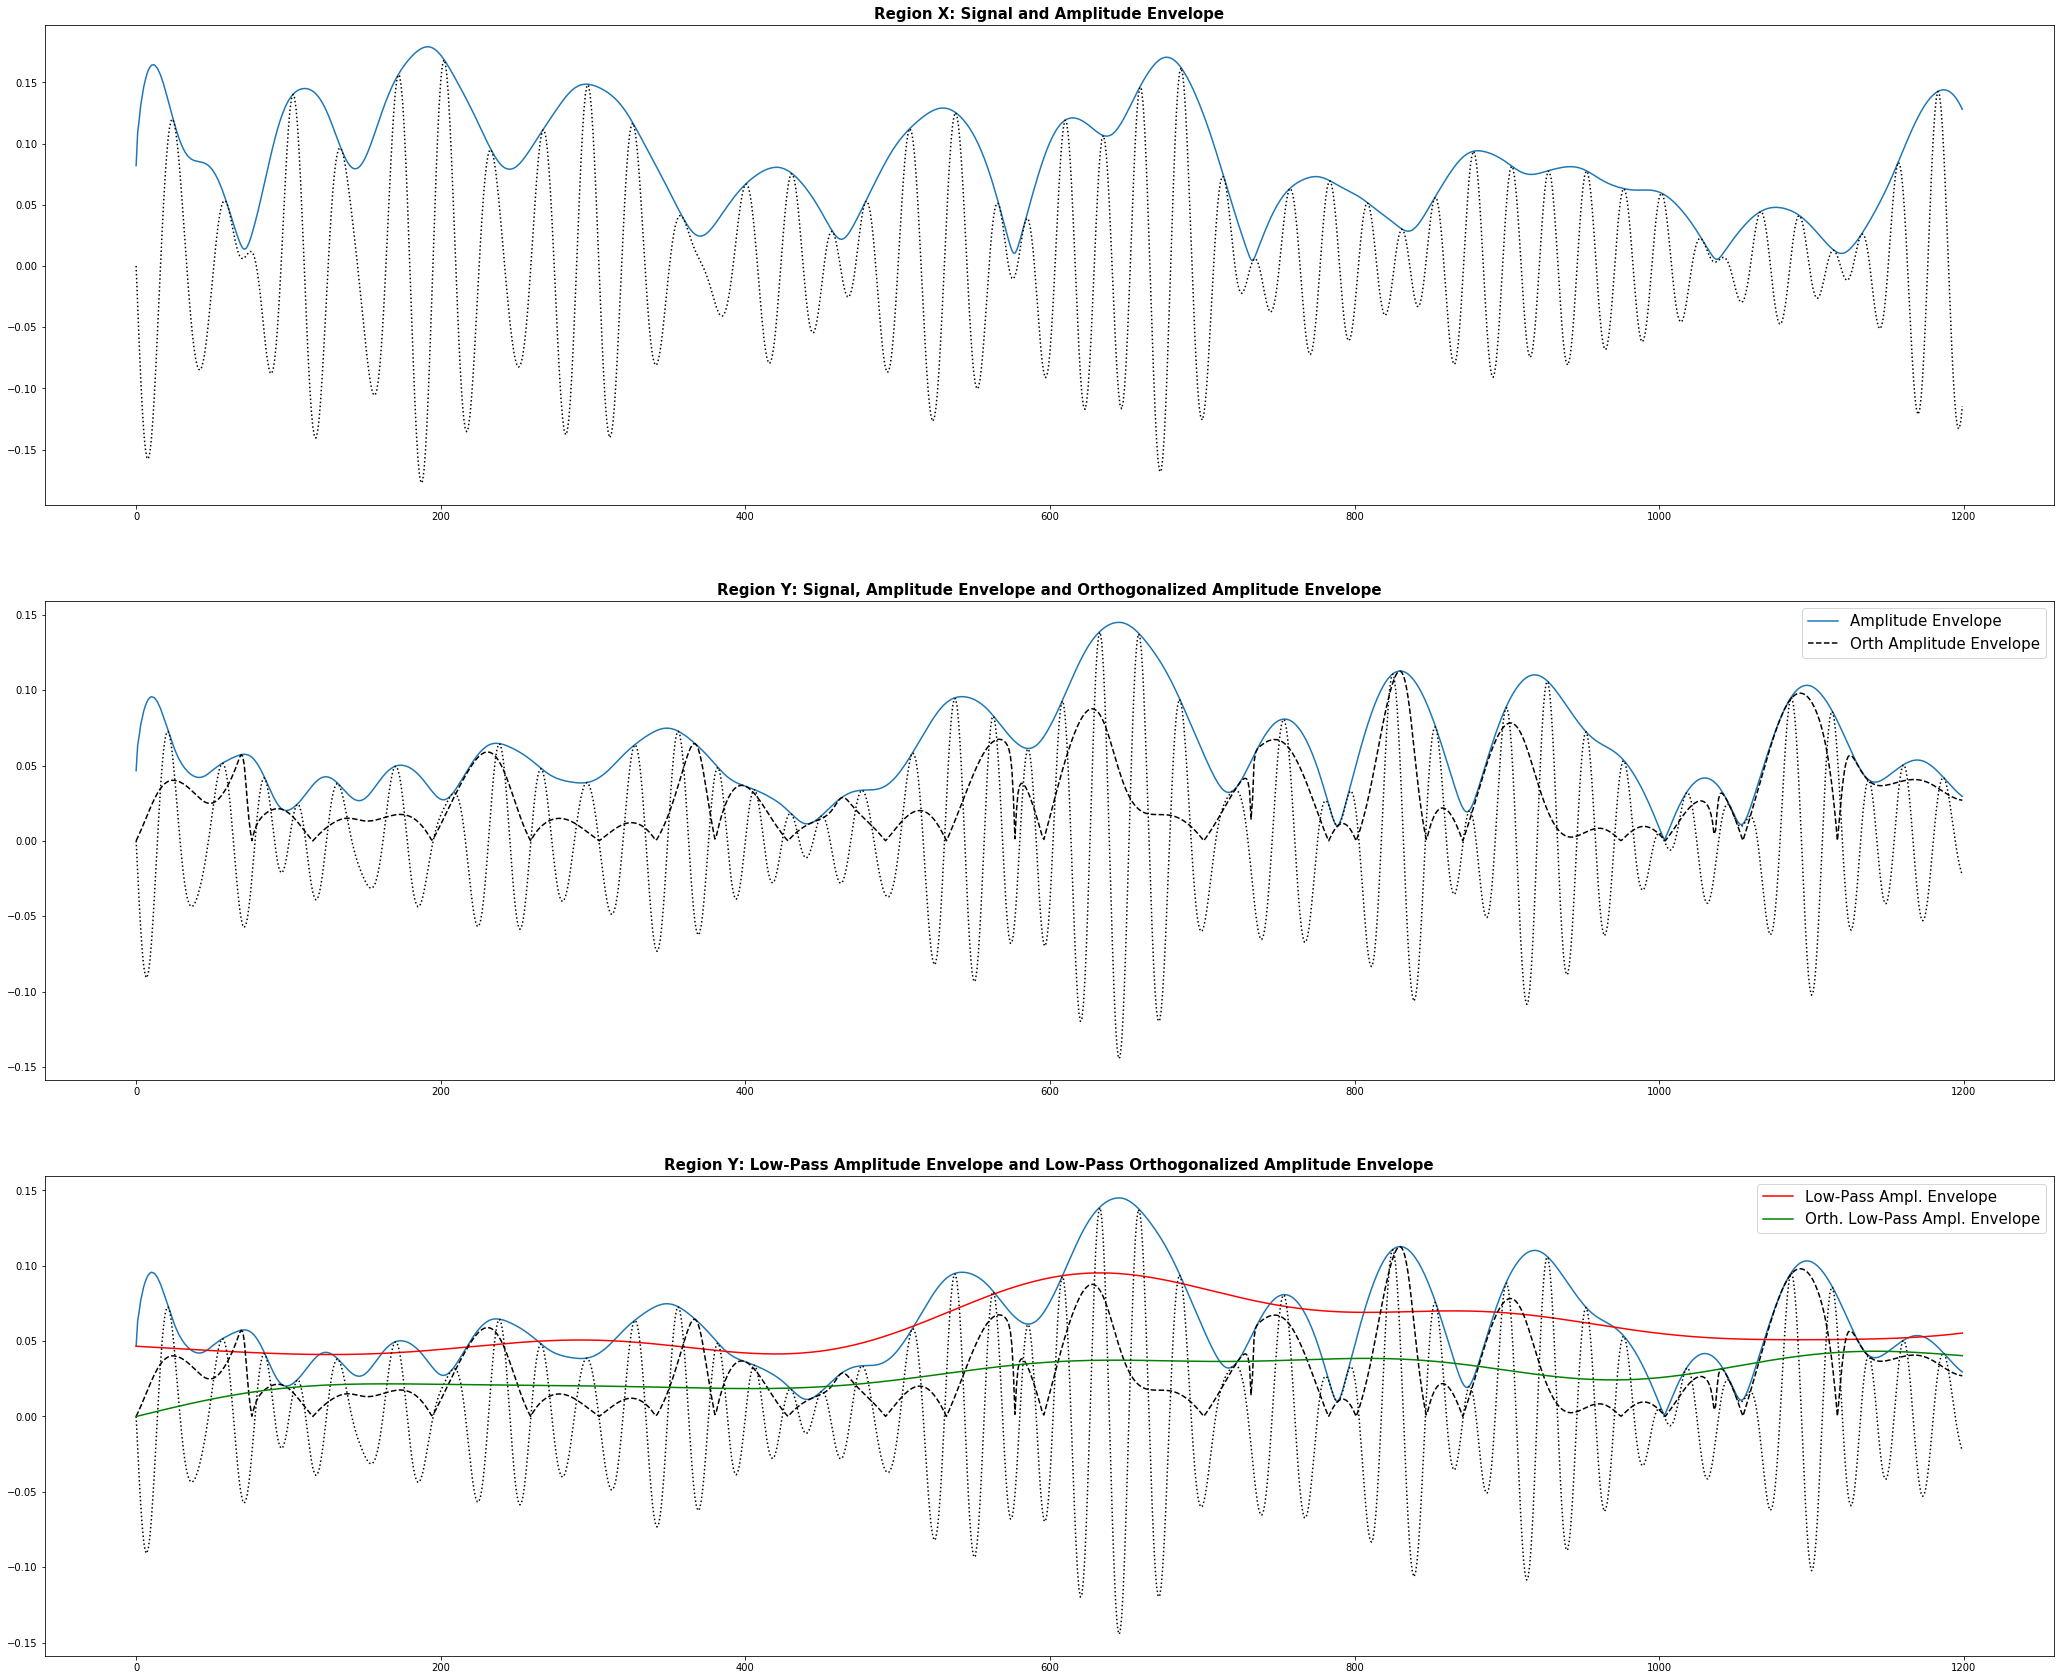

In [23]:
plot_signal = 14
timepoints = 1200
region_Y = 1 
region_X = 0

mag = dict_mag[plot_signal]
low_mag = dict_low_mag[plot_signal]
signal = dict_signals[plot_signal]
orth_mag = dict_orth_mag[plot_signal]
low_orth_mag = dict_low_orth_mag[plot_signal]

plt.figure(figsize=(36,30))
plt.subplot(3,1,1)
plt.plot(mag[region_X, :timepoints])
plt.plot(signal[region_X, :timepoints], ':k')
plt.title(f'Region X: Signal and Amplitude Envelope', fontweight='bold',fontsize=15)

plt.subplot(3,1,2)
plt.plot(mag[region_Y,:timepoints], label='Amplitude Envelope')
plt.plot(signal[region_Y,:timepoints], ':k')
plt.plot(orth_mag[region_Y, region_X, :timepoints], '--k', label='Orth Amplitude Envelope')
plt.title(f'Region Y: Signal, Amplitude Envelope and Orthogonalized Amplitude Envelope', fontweight='bold',fontsize=15)
plt.legend(fontsize=15)

plt.subplot(3,1,3)
plt.plot(mag[region_Y,:timepoints])
plt.plot(low_mag[region_Y,:timepoints], 'r', label='Low-Pass Ampl. Envelope')
plt.plot(signal[region_Y,:timepoints], ':k')
plt.plot(orth_mag[region_Y, region_X, :timepoints], '--k')
plt.plot(low_orth_mag[region_Y, region_X, :timepoints], 'g', label='Orth. Low-Pass Ampl. Envelope')
plt.title(f'Region Y: Low-Pass Amplitude Envelope and Low-Pass Orthogonalized Amplitude Envelope', fontweight='bold',fontsize=15)
plt.legend(fontsize=15)

### Compute Correlation of Low-Pass Amplitude Envelopes

In [24]:
dict_low_corr={} # Initialize correlation dictionary

for signal_name in dict_low_mag:
    low_mag = dict_low_mag[signal_name]
    low_orth_mag = dict_low_orth_mag[signal_name]
    
    # Centralize data for correlation
    low_mag -= np.mean(low_mag, axis=-1, keepdims=True)
   
    low_mag_std = np.linalg.norm(low_mag, axis=-1) # Calculate the standard deviation using np.linalg.norm which squares, sums and takes the root
    low_mag_std[np.isclose(low_mag_std,0)] = 1 # Eliminates zeros which produce error during pearson correlation
    
    # Iteration over envelopes
    corr = np.empty((N,N))
    for n, n_low_mag in enumerate(low_mag): # Iterates over N, low_orth_mag is a NxNxT
        
        n_orth_mag = low_orth_mag[:,n,:] # Get amplitude envelopes of all regions that have been orthogonalized to n
        n_orth_mag -= np.mean(n_orth_mag, axis=-1, keepdims=True) # Centralize the data
        n_orth_mag_std = np.linalg.norm(n_orth_mag, axis=-1) # Compute standard deviation
        n_orth_mag_std[np.isclose(n_orth_mag_std,0)] = 1 # Sets std close to zero to 1
        
        # Correlation between the envelope of all regions - orthogonalized with respect to n - and the envelope of the region
        # n_orth_mag.shape = N,T, low_mag[n].shape = T,
        
        corr[n] = np.dot(n_orth_mag, n_low_mag) # Yields NxN covmat 
        corr[n] /= low_mag_std[n] # Division by standard deviation
        corr[n] /= n_orth_mag_std
        
    # Correlation matrix is not symmetric because the orthogonalization is asymmetric. 
    # To make the matrix symmetric we take the average of the two correlations. This is done by (m+m.T)/2
        
    corr = (corr.T + corr)/2.
    
    dict_low_corr[signal_name]=corr*(1/0.577) # Correction for Underestimation of the correlation (Hipp 2012)   
print(dict_low_corr.keys())

dict_keys([4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28])


### Plot Functional Connectivity of Low-Pass Envelope

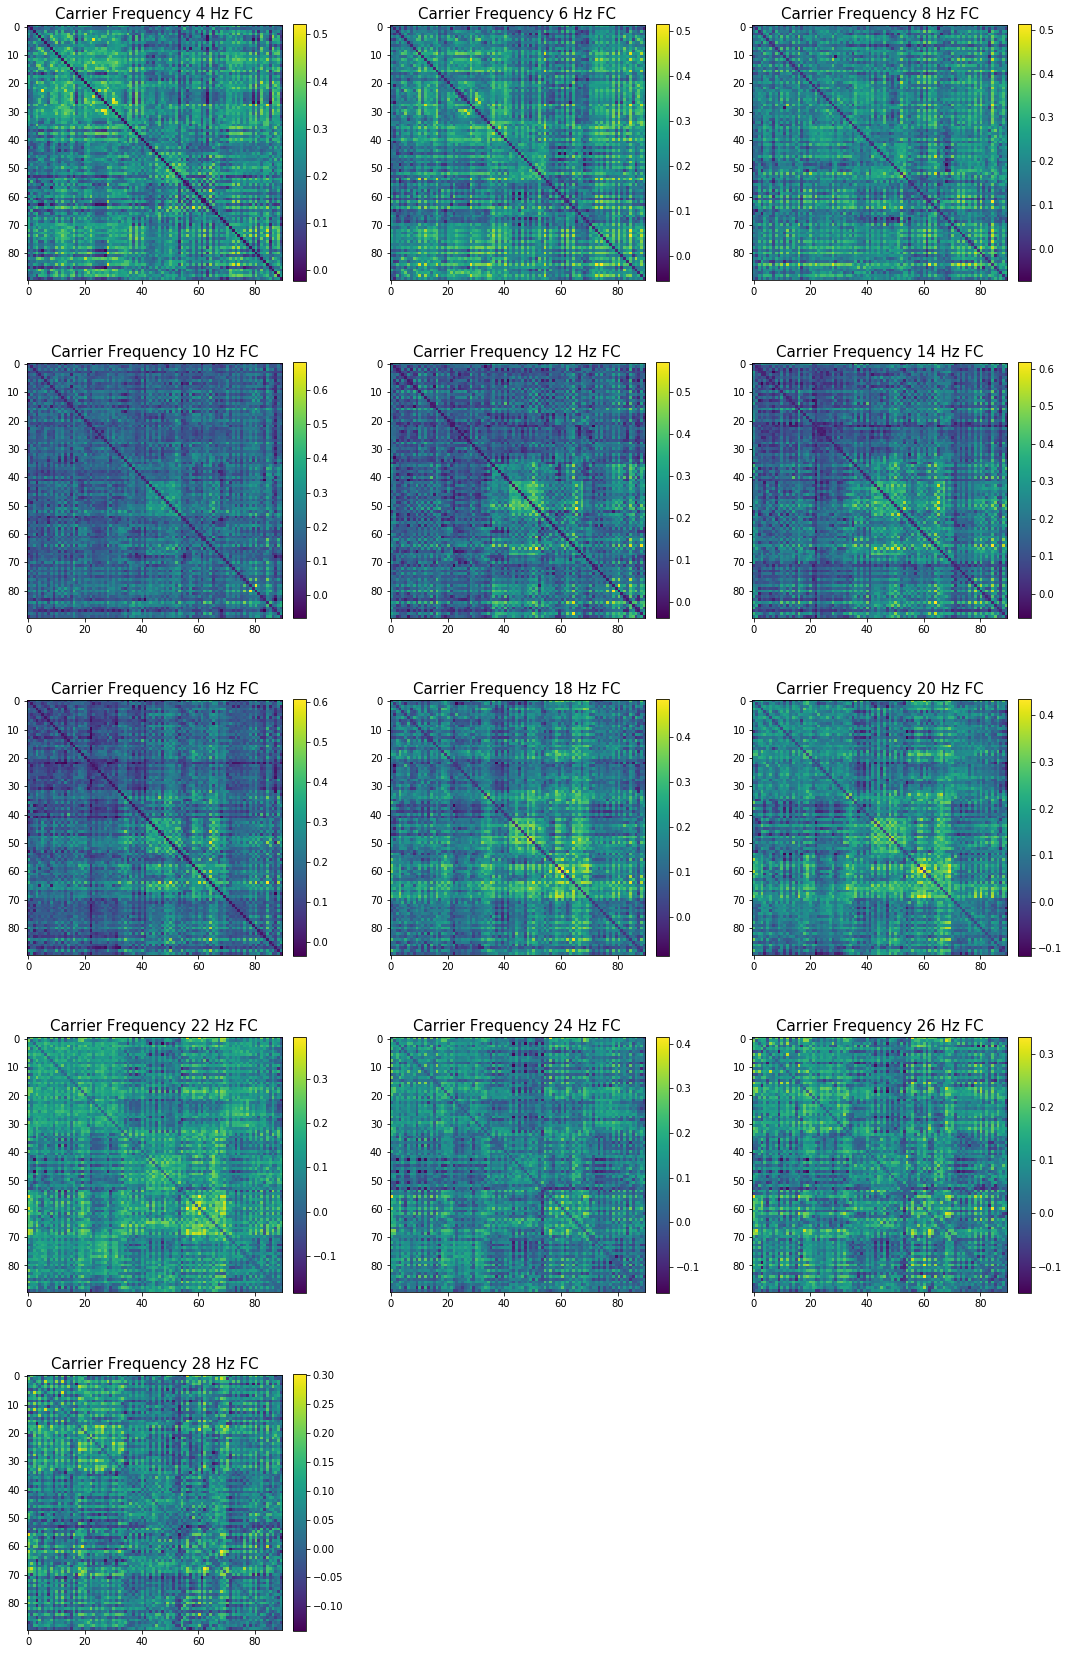

In [28]:
fig = plt.figure(figsize=(18,30))
nplotrows = int(np.ceil(len(dict_low_corr)/3))
for num, signal in enumerate(dict_low_corr):
    ax = fig.add_subplot(nplotrows, 3, num+1)
    cax = ax.imshow(dict_low_corr[signal])
    fig.colorbar(cax, fraction=0.046, pad=0.04)
    ax.set_title(f"Carrier Frequency {signal} Hz FC", fontsize=15)
fig.subplots_adjust(wspace=0.3)

## Plot of Frequency-Bands

### First band

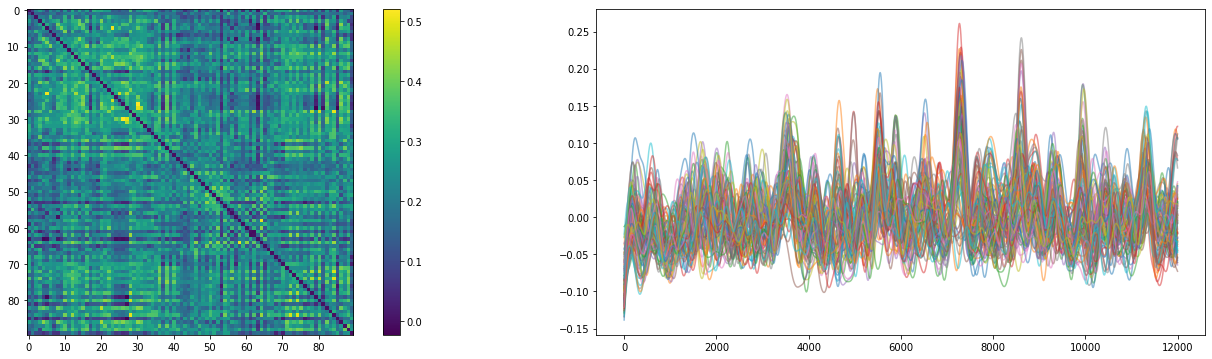

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(24, 6))
im=axs[0].imshow(dict_low_corr[4])
fig.colorbar(im, ax=axs[0])
for n in range(N):
    axs[1].plot(dict_low_mag[4][n,:12000],alpha=0.5)

### Save extracted amplitude envelopes and FC matrices

In [32]:
results_dir = r'/mnt/antares_raid/home/fkamp/Glasgow_rsMEG/results_'+Subject
if not os.path.isdir(results_dir):
    os.mkdir(results_dir)

os.chdir(results_dir)

for s in dict_fband:
    np.save('FrqCarrier-'+s.astype(str)+'_low-ampl-env_FC.npy',dict_low_corr[s])
    np.save('FrqCarrier-'+s.astype(str)+'_ampl-env.npy',dict_mag[s])
    np.save('FrqCarrier-'+s.astype(str)+'_low-ampl-env.npy',dict_low_mag[s])
    

## Functional Connectivity of the Envelope (No Low-Pass Filter)

In [33]:
dict_corr={} # Initialize correlation dictionary

for signal_name in dict_mag:
    mag = dict_mag[signal_name]
    orth_mag = dict_orth_mag[signal_name]
    
    # Centralize data for correlation
    mag -= np.mean(mag, axis=-1, keepdims=True)
   
    mag_std = np.linalg.norm(mag, axis=-1) # Calculate the standard deviation using np.linalg.norm which squares, sums and takes the root
    mag_std[np.isclose(mag_std,0)] = 1 # Eliminates zeros which produce error during pearson correlation
    
    # Iteration over envelopes
    corr = np.empty((N,N))
    for n, n_mag in enumerate(mag): # Iterates over N, orth_mag is a NxNxT
        
        n_orth_mag = orth_mag[:,n,:] # Get amplitude envelopes of all regions that have been orthogonalized to n
        n_orth_mag -= np.mean(n_orth_mag, axis=-1, keepdims=True) # Centralize the data
        n_orth_mag_std = np.linalg.norm(n_orth_mag, axis=-1) # Compute standard deviation
        n_orth_mag_std[np.isclose(n_orth_mag_std,0)] = 1 # Sets std close to zero to 1
        
        # Correlation between the envelope of all regions - orthogonalized with respect to n - and the envelope of the region
        # n_orth_mag.shape = N,T, mag[n].shape = T,
        
        corr[n] = np.dot(n_orth_mag, n_mag) # Yields NxN covmat 
        corr[n] /= mag_std[n] # Division by standard deviation
        corr[n] /= n_orth_mag_std
        
    # Correlation matrix is not symmetric because the orthogonalization is asymmetric. 
    # To make the matrix symmetric we take the average of the two correlations. This is done by (m+m.T)/2
        
    corr = (corr.T + corr)/2.
    
    dict_corr[signal_name]=corr*(1/0.577) # Correction for Underestimation of the correlation (Hipp 2012)   
print(dict_corr.keys())

dict_keys([4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28])


In [34]:
results_dir = r'/mnt/antares_raid/home/fkamp/Glasgow_rsMEG/results_'+Subject
os.chdir(results_dir)

for s in dict_fband:
    np.save('FrqCarrier-'+s.astype(str)+'_ampl-env_FC.npy',dict_corr[s])